# 1. Sentiment analysis with Langchain 
## 1.1. What is Langchain ?
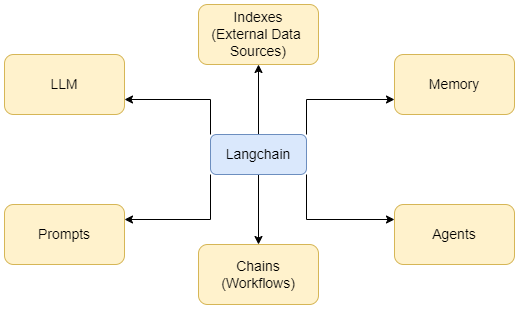

In [1]:
import json
import os

with open('vars.json') as f:
  data = json.load(f)

openai_api_key = data["open_ai_api_key"]
# langchain_api_key = data["langchain_api_key"]

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

## 1.2. Storing feedbacks in a Vector Database 
### 1.2.1. Vector Database Demo
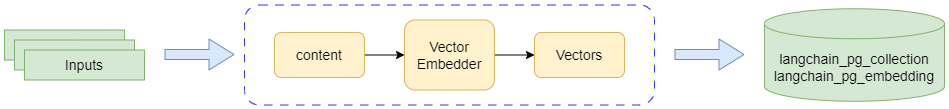

In [2]:
from langchain_core.documents import Document

collection_name = "Footballers"

docs = [
    Document(
        page_content="My name is Mbappe and I live in Paris.",
        metadata={'player_id': '1', 'created_ts': '2024-05-01 00:00:00.000'},
    ),
    Document(
        page_content="My name is Jude and I live in Madrid.",
        metadata={'player_id': '2', 'created_ts': '2024-05-02 00:00:00.000'},
    ),
    Document(
        page_content="My name is Pedri and I live in Barcelona.",
        metadata={'player_id': '3', 'created_ts': '2024-05-03 00:00:00.000'},
    ),
    Document(
        page_content="My name is Erlang and I live in Manchester.",
        metadata={'player_id': '4', 'created_ts': '2024-05-04 00:00:00.000'},
    )
]

In [3]:
from langchain_postgres.vectorstores import PGVector
from langchain_openai.embeddings import OpenAIEmbeddings

# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16

# Store data in vector database 
db_config = {
    'dbname': 'langchain',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"
embeddings = OpenAIEmbeddings(
    openai_api_key=openai_api_key,
    model="text-embedding-3-large"
)

vectorstore = PGVector(
    embeddings=embeddings,
    connection=connection_string,
    collection_name=collection_name,
    use_jsonb=True,
)
vectorstore.drop_tables()
vectorstore.from_documents(
    documents=docs,
    collection_name=collection_name,
    embedding=embeddings,
    connection=connection_string
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [4]:
retriever.invoke("Where does Pedri live?")

[Document(page_content='My name is Pedri and I live in Barcelona.', metadata={'player_id': '3', 'created_ts': '2024-05-03 00:00:00.000'})]

In [5]:
retriever.invoke("Who lives in France?", k=1)

[Document(page_content='My name is Mbappe and I live in Paris.', metadata={'player_id': '1', 'created_ts': '2024-05-01 00:00:00.000'})]

### 1.2.2. Storing feedbacks

In [6]:
collection_name = "customer_feedbacks"

docs = [
    Document(
        page_content="""I recently purchased your product and I must say, the quality is absolutely fantastic! From the moment I unboxed it, I could tell that a lot of thought and care had gone into its design and manufacturing. The materials used are top-notch and it performs even better than I had expected. It’s clear that your company values craftsmanship and customer satisfaction, and I am extremely pleased with the product itself.

However, I did experience an issue with the delivery. The package arrived significantly later than the estimated delivery date provided at the time of purchase. While I understand that sometimes delays can occur due to unforeseen circumstances, it was a bit frustrating to wait longer than anticipated, especially because I was eager to start using my new product.

Despite the delay, the product quality has definitely won me over, and I will not hesitate to recommend your company to friends and family. I hope that future deliveries will be more punctual, as that would make the overall experience perfect. Thank you for creating such an excellent product and I look forward to seeing improvements in the delivery process.""",
        metadata={'cust_id': '1', 'created_ts': '2024-05-01 00:00:00.000'},
    ),
    Document(
        page_content="""I recently had the pleasure of experiencing your customer service, and I am delighted to share my feedback. The service I received was excellent from start to finish. I had a few questions regarding a product I was interested in, and I reached out to your support team for assistance. To my pleasant surprise, I received a response almost immediately.

The support team was incredibly helpful and knowledgeable. They answered all my queries thoroughly and provided detailed information that helped me make an informed decision. What stood out the most was their friendly and professional demeanor. It’s not often that you encounter such a high level of customer service, and it made a significant difference in my overall experience.

The quick response time was particularly impressive. In an age where waiting days for a reply has become the norm, your team's efficiency was refreshing. It showed a genuine commitment to customer satisfaction and made me feel valued as a customer.

I am extremely satisfied with the service provided and will certainly recommend your company to others. Excellent service and prompt support are rare these days, and you have set a high standard. Thank you for the outstanding experience.""",
        metadata={'cust_id': '2', 'created_ts': '2024-05-02 00:00:00.000'},
    ),
    Document(
        page_content="""I recently purchased one of your products and wanted to share my thoughts. Overall, I am quite pleased with the product. It performs well and meets the standards I was hoping for. The quality is evident in its design and functionality, and it has proven to be reliable and efficient in my daily use.

However, while the product is good, I do feel that the price is on the higher side. Given the competitive market, I believe that a more affordable pricing structure could make this product even more appealing. While I am satisfied with what I received, I think a slight reduction in price would provide better value for customers like me.

I understand that quality often comes at a cost, and I appreciate the excellence your brand represents. Still, a more budget-friendly option could attract a wider audience without compromising the quality you’re known for.

Despite this, I am happy with my purchase and will continue to use the product. I hope that future pricing can be adjusted to reflect a more competitive rate, which would undoubtedly make this an unbeatable choice in the market.

Thank you for delivering a high-quality product. I look forward to seeing potential improvements in pricing.""",
        metadata={'cust_id': '3', 'created_ts': '2024-05-03 00:00:00.000'},
    ),
    Document(
        page_content="""I recently had an experience with your customer service that I feel compelled to share. Unfortunately, I was not satisfied with the level of service provided. I reached out with a query regarding a product I purchased, expecting a prompt and helpful response. However, my experience was quite the opposite.

Firstly, the response time was far longer than anticipated. I had to wait several days before receiving any acknowledgment of my inquiry. When I finally did get a reply, the information provided was vague and did not address my specific concerns. It felt as though my issue was not given the attention it deserved.

Furthermore, the representative I spoke with did not seem knowledgeable about the product or the policies of your company. This lack of expertise was frustrating and did not inspire confidence in your customer support system. I had to repeat my questions multiple times, and even then, the answers were unsatisfactory and incomplete.

Customer service is a critical aspect of any business, and I believe there is significant room for improvement in this area. I hope that future interactions will be more efficient and effective. I am disappointed with this experience and hope it does not reflect the overall values of your company.

Thank you for taking the time to consider my feedback. I look forward to seeing improvements in your customer service.""",
        metadata={'cust_id': '4', 'created_ts': '2024-05-04 00:00:00.000'},
    )
]

In [7]:
# Store data in vector database 
vectorstore = PGVector(
    embeddings=embeddings,
    connection=connection_string,
    collection_name=collection_name,
    use_jsonb=True,
)
vectorstore.drop_tables()
vectorstore.from_documents(
    documents=docs,
    collection_name=collection_name,
    embedding=embeddings,
    connection=connection_string
)

In [8]:
# Extracting data from PGvector database 
import psycopg2

try:
    connection = psycopg2.connect(
        host=db_config['host'],
        port=db_config['port'],
        database=db_config['dbname'],
        user=db_config['user'],
        password=db_config['password']
    )

    cursor = connection.cursor()

    sql_query = """
    SELECT document FROM langchain_pg_embedding 
    """

    # Execute the query
    cursor.execute(sql_query)

    # Fetch all the results
    results = cursor.fetchall()
    results_list = []

    # Process the results
    for row in results:
        results_list.append(row[0])

except psycopg2.Error as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

In [9]:
for i in range(len(results_list)):
    results_list[i] = {"feedback": results_list[i]}
    print(results_list[i]["feedback"][:100] + "...")

I recently purchased your product and I must say, the quality is absolutely fantastic! From the mome...
I recently had the pleasure of experiencing your customer service, and I am delighted to share my fe...
I recently purchased one of your products and wanted to share my thoughts. Overall, I am quite pleas...
I recently had an experience with your customer service that I feel compelled to share. Unfortunatel...


## 1.3. Using ChatGPT to get the sentiment score 
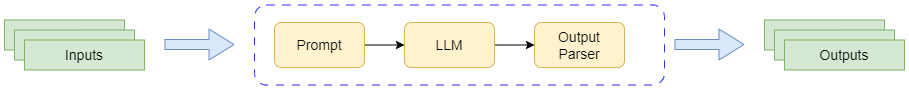

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

model = ChatOpenAI(
    # model="gpt-4o",
    model="gpt-3.5-turbo-0613",
    api_key=openai_api_key
)

prompt = ChatPromptTemplate.from_template("Can you please give me a sentiment score for this customer feedback on a scale of 1 to 10, where 1 represents extremely negative sentiment and 10 represents extremely positive sentiment? {feedback}")

chain = prompt | model | StrOutputParser()

In [11]:
# output = chain.invoke({"feedback": "The product quality is fantastic, but the delivery was late."})
output = chain.batch([{"feedback": "The product quality is fantastic, but the delivery was late."}, {"feedback": "Not satisfied with the customer service."}])

for result in output:
    print(result)
    print("---------------")

Based on the given customer feedback, I would assign a sentiment score of 7. The customer acknowledges the fantastic product quality, which indicates a positive sentiment. However, the late delivery slightly affects the overall sentiment, bringing it down from a higher score.
---------------
Based on the given feedback, it is clear that the customer is expressing dissatisfaction with the customer service. This indicates a negative sentiment. Therefore, the sentiment score for this customer feedback could be around 3 or 4 on a scale of 1 to 10.
---------------


## 1.4. Changing the output structure 

In [12]:
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class FeedbackAnalysis(BaseModel):
    """Information from Feedback"""
    
    rating: int = Field(
        description="The sentiment score which is calculated using the customer feedback. It has to be on a scale of 1 to 10, where 1 represents extremely negative sentiment and 10 represents extremely positive sentiment"
    )
    summary: str = Field(
        default=None, 
        description=("A very short summary of the feedback with keywords and phrases which have affected the sentiment score."
                    "This has to be less than 30 words. Make it as short as possible.")
    )

chain = prompt | model.with_structured_output(schema=FeedbackAnalysis)

result = chain.invoke(results_list[0])
print(result.__dict__)

C:\Users\Sudheera\anaconda3\envs\langchain_python_3_10_14\lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The method `ChatOpenAI.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


{'rating': 9, 'summary': 'Fantastic product quality, but experienced delay in delivery'}


In [13]:
result = chain.invoke(results_list[0])
print(result.__dict__)

{'rating': 9, 'summary': 'Excellent product quality, but experienced a delivery delay'}


In [14]:
result = chain.invoke(results_list[0])
print(result.__dict__)

{'rating': 9, 'summary': 'Excellent product quality, but experienced a delay in delivery'}


In [15]:
output_list = chain.batch(results_list)

In [16]:
for output in output_list:
    print(output.__dict__)
    print("---------------")

{'rating': 9, 'summary': 'Fantastic product quality, but experienced a delivery delay'}
---------------
{'rating': 9, 'summary': 'Excellent service from start to finish. Incredibly helpful and knowledgeable support team. Friendly and professional demeanor. Quick response time. Extremely satisfied and will recommend.'}
---------------
{'rating': 8, 'summary': 'Pleased with the product, but price could be lower'}
---------------
{'rating': 3, 'summary': 'Not satisfied with level of service, long response time, vague information, lack of knowledge'}
---------------
